# Exercise Sheet 5: Fairness
## Problem 03


In [2]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LogisticRegression

(c) Generate a data set $\mathcal{D} $ of size $N=100$ in the following way:  

	
- Sample each $x_i$ according to a standard normal distribution;	
- Sample $u_i$ uniformly at random from the unit interval;
- Set $y_i= 1 \{ u_i < \exp(x_i)/(1+\exp(x_i)) \}$

**Note that we identify here the class label "-1" with "0" for sake of simplicity**


In [3]:
def sample_pair(squared_x=False):
    x = np.random.normal(0,1,size=1)
    u = np.random.uniform(0,1,size=1)
    if not squared_x: 
        y = 1*(u<np.exp(x)/(1+np.exp(x)))
    else:
        y = 1*(u<np.exp(x**2)/(1+np.exp(x**2)))
    return x,y

In [4]:
def gen_train(N,squared_x=False):
    x,y = sample_pair(squared_x)
    X   = x
    Y   = y
    for i in range(1,N):
        x,y = sample_pair(squared_x)
        X = np.vstack((X, x))
        Y = np.concatenate((Y, y), axis=0)
    return X,Y

In [10]:
gen_train(5)

(array([[ 0.4099345 ],
        [-0.1145206 ],
        [ 0.53623977],
        [-1.46406021],
        [-0.56773416]]),
 array([0, 0, 1, 0, 1]))

Fit a logistic regression model $h_{\theta}$ to the data 

In [5]:
N    = 100
X, y = gen_train(N) 
h    = LogisticRegression(fit_intercept=False).fit(X, y)
print(h.predict(X[1:10]))              # Predict class labels for samples in X.
print(h.predict_proba(X[1:10]))        # Predict probability estimates.            
print(h.coef_[0][0])                   # Get parameter \theta of the fitted model.

[1 1 0 1 1 1 0 0 0]
[[0.16008682 0.83991318]
 [0.07386245 0.92613755]
 [0.60397627 0.39602373]
 [0.20161794 0.79838206]
 [0.10365097 0.89634903]
 [0.14490868 0.85509132]
 [0.91444955 0.08555045]
 [0.58887569 0.41112431]
 [0.63099784 0.36900216]]
1.3293962458592115


Plot reliability diagrams with $B\in\{10,20,50\}$, where you use a binning with bins of equal width.

In [6]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

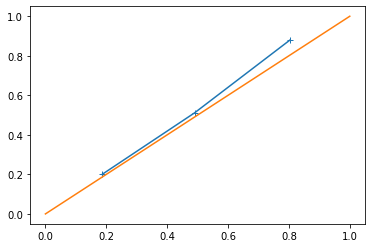

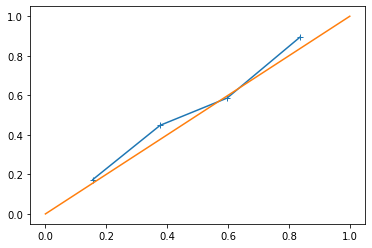

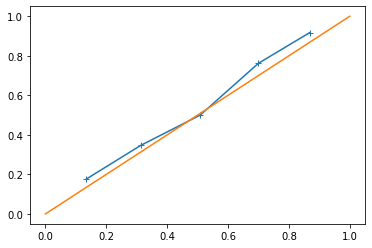

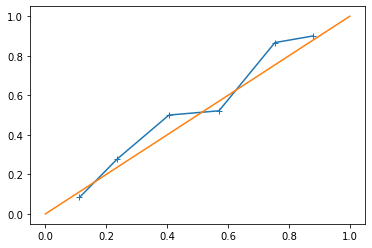

In [7]:

for B in [3,4,5,6]:
    y_true = y
    y_pred = h.predict_proba(X)[:,1].flatten()
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=B)

    plt.plot( prob_pred,prob_true,ls='-',marker='+')
    plt.plot( np.linspace(0, 1, B),np.linspace(0, 1, B))
    plt.show()

Next, compute $H_{\vec{\theta}}(G) = \sum_{g=1}^G \frac{( O_{g,+1} - E_{g,+1|{\vec{\theta}}})^2 }{E_{g,+1|{\vec{\theta}}}} + \frac{( O_{g,-1} - E_{g,-1|{\vec{\theta}}})^2 }{E_{g,-1|{\vec{\theta}}}},$ 
for different values of $G,$ say $G\in\{5,\ldots,15\},$ where you use a suitable partition $\mathcal{X}_1,\ldots,\mathcal{X}_G$ of $\mathcal{X}. $

A convenient way to store and group the data is by using pandas DataFrames 

In [38]:
XY_pd                = pd.DataFrame(X,columns=['x'])  
XY_pd['y']           = y
XY_pd['group']       = pd.qcut(XY_pd['x'], q=2) # categorizes the DataFrame in q many categrories each having approx. the same number of data

XY_pd

,x,y,group
0,-0.569860,0,"(-3.367, 0.275]"
1,0.239088,1,"(-3.367, 0.275]"
2,0.320899,0,"(0.275, 2.074]"
3,0.531801,1,"(0.275, 2.074]"
4,-0.862587,0,"(-3.367, 0.275]"
...,...,...,...
95,0.363305,0,"(0.275, 2.074]"
96,1.782405,0,"(0.275, 2.074]"
97,0.505344,1,"(0.275, 2.074]"
98,0.542928,0,"(0.275, 2.074]"


In [40]:
XY_pd['h_theta_p1']  = h.predict_proba(X)[:,1].flatten()
XY_pd['h_theta_m1']  = 1-XY_pd['h_theta_p1']

In [41]:
XY_pd.groupby(['group']).count()-XY_pd.groupby(['group']).sum() # number of y's with y=0

,x,y,h_theta_p1,h_theta_m1
group,,,,
"(-3.367, 0.275]",86.206789,34,32.510048,17.489952
"(0.275, 2.074]",4.954795,14,15.078029,34.921971


In [42]:
XY_pd.groupby(['group']).sum() # number of y's with y=1

,x,y,h_theta_p1,h_theta_m1
group,,,,
"(-3.367, 0.275]",-36.206789,16,17.489952,32.510048
"(0.275, 2.074]",45.045205,36,34.921971,15.078029


With this we can compute the value of $H_{\vec{\theta}}$ quite easily

In [8]:
def H(G,X=X,y=y,h=h):
    H_val                = 0
    XY_pd                = pd.DataFrame(X,columns=['x'])  
    XY_pd['y']           = y
    XY_pd['group']       = pd.qcut(XY_pd['x'], q=G)
    XY_pd['h_theta_p1']  = h.predict_proba(X)[:,1].flatten()
    XY_pd['h_theta_m1']  = 1-XY_pd['h_theta_p1']

    temp_df1 = XY_pd.groupby(['group']).count()-XY_pd.groupby(['group']).sum()
    temp_df2 = XY_pd.groupby(['group']).sum()
    
    for i in range(G):
        H_val = H_val + ((temp_df1['y'][i]-temp_df1['h_theta_p1'][i])**2)/(temp_df1['h_theta_p1'][i]) + ((temp_df2['y'][i]-temp_df2['h_theta_p1'][i])**2)/(temp_df2['h_theta_p1'][i])
    return (H_val)

The values of $H_{\vec{\theta}}(G)$ for $G\in\{5,\ldots,15\}$

In [9]:
H_vals = [H(g) for g in range(5,16,1)]
print( H_vals)

[0.9148729204849181, 1.6035869274289012, 1.9243424056703229, 2.5378923742110864, 3.5274374733854788, 3.235036473531596, 5.250113504703048, 5.613354216790727, 8.172564450101843, 7.22487605850982, 4.740998863812788]


Repeat this whole procedure (of computing $H_{\theta}(G)$) for 1000 times and compute the average over the computed $H_{\theta}(G)$ values and plot these averages as a function of $G$ into one figure.

In [10]:

def avg_H_vals(reps=1000,squared_x=False):
    N    = 1000
    X, y = gen_train(N,squared_x) 
    h    = LogisticRegression(fit_intercept=False).fit(X, y)
    H_vals = [H(g,X=X,y=y,h=h) for g in range(5,16,1)]
    H_all = pd.DataFrame(H_vals, index=[str(i) for i in range(5,16,1)]) 
    for i in range(1,reps):
        X, y = gen_train(N,squared_x) 
        h    = LogisticRegression(fit_intercept=False).fit(X, y)
        H_all[i] = [H(g,X=X,y=y,h=h) for g in range(5,16,1)]
    return H_all.mean(axis=1)
        

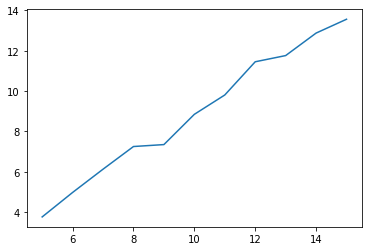

In [11]:
plt.plot(range(5,16,1),avg_H_vals(100))

(d) Generate a data set $\mathcal{D} $ of size $N=100$ in the following way:  

	
- Sample each $x_i$ according to a standard normal distribution;	
- Sample $u_i$ uniformly at random from the unit interval;
- Set $y_i= 1 \{ u_i < \exp(x_i^2)/(1+\exp(x_i^2)) \}$

**Note that we identify here the class label "-1" with "0" for sake of simplicity**

Repeat (c) for this data generating process and include the resulting average curve into the figure of (c).

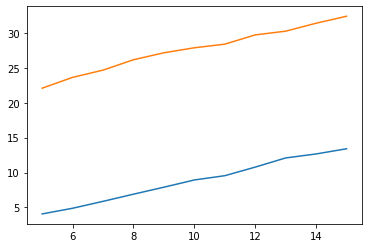

In [20]:
plt.plot(range(5,16,1),avg_H_vals(100))
plt.plot(range(5,16,1),avg_H_vals(100,squared_x=True))